In [1]:
import json
import numpy as np
import pandas as pd
from datetime import *
from dateutil import parser, tz

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# get rid of gridlines 
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

import imp
sentiment = imp.load_source('sentiment', '/Users/andrew/git-local/sentiment.py')

In [2]:
labMT, mtList, wordList = sentiment.emotionFileReader(1.0, returnVector=True)

In [3]:
raw = []
for hr in ['19','20','21','22','23']:
    with open(hr+'.txt','r') as f:
        raw.extend(f.readlines())
        
# read in as array of dicts
rows = np.array([json.loads(line) for line in raw])
# we only need some of these keys, and the others may cause trouble for pandas
keys = np.array(['first_term','text','timestamp','tweet_id','username'])
for row in rows:
    for k in row.keys():
        if k not in keys:
            del row[k]
            
df = pd.DataFrame.from_records(rows)

In [4]:
def update_tz(d):
    ''' Updates time zone for date stamp to US EST (the time zone of the debates) '''
    def convert_timezone(item):
        from_zone = tz.gettz('UTC')
        to_zone = tz.gettz('America/New_York')
        utc = d.replace(tzinfo=from_zone)
        return utc.astimezone(to_zone)
    
    return convert_timezone(d)

In [5]:
interval = 30
df['timestamp'] = pd.to_datetime(df.timestamp)
df['timestamp'] = df.timestamp.apply(
                    lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour, 
                                        dt.minute,interval*(dt.second // interval))
                  )
df.timestamp = df.timestamp.apply(update_tz)

Note: If making histograms, limit df to time of debate. Eg. dem oct 13 debate is 830-11pm

In [10]:
start_time = datetime.strptime("20:30:00","%H:%M:%S").time()
end_time = datetime.strptime("23:00:00","%H:%M:%S").time()
actualdf = df.ix[(df.timestamp.dt.time >= start_time) & (df.timestamp.dt.time <= end_time),:]

In [11]:
actualdf.shape

(84022, 5)

In [6]:
g = df.groupby(['first_term',pd.TimeGrouper(str(interval)+'S',key="timestamp")])

In [13]:
ctdf = pd.DataFrame(g.text.count()).reset_index()

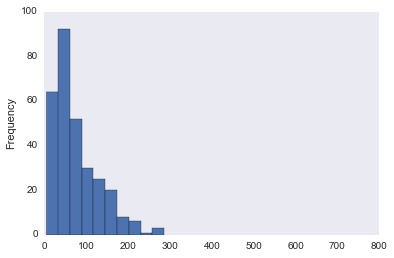

In [277]:
# tweets per 30 second interval between 8pm and 11pm: CLINTON
_=ctdf.ix[ctdf.first_term=="clinton","text"].plot(kind='hist',bins=10,xlim=(0,800),ylim=(0,100))

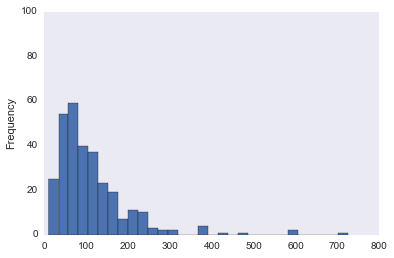

In [275]:
# tweets per 30 second interval between 8pm and 11pm: SANDERS
_=ctdf.ix[ctdf.first_term=="sanders","text"].plot(kind='hist',bins=30,xlim=(0,800),ylim=(0,100))

In [219]:
#sanders has crazy tweets from 9:49-9:50!!
ctdf.ix[(ctdf.first_term=="sanders") & (ctdf.text>500),:]

,first_term,timestamp,text
1051,sanders,2015-10-13 21:49:00-04:00,583
1052,sanders,2015-10-13 21:49:30-04:00,725
1053,sanders,2015-10-13 21:50:00-04:00,601


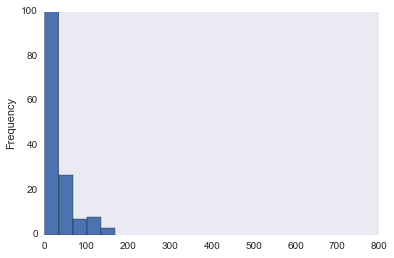

In [278]:
# tweets per 30 second interval between 8pm and 11pm: OMALLEY
_=ctdf.ix[ctdf.first_term=="omalley","text"].plot(kind='hist',bins=5,xlim=(0,800),ylim=(0,100))

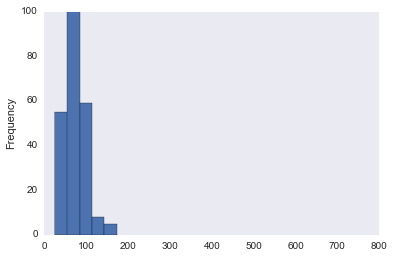

In [279]:
# tweets per 30 second interval between 8pm and 11pm: GENERAL
_=ctdf.ix[ctdf.first_term=="general","text"].plot(kind='hist',bins=5,xlim=(0,800),ylim=(0,100))

In [87]:
candidate_dict = {}
candidate_names = df.first_term.unique()
tweet_counts = g.text.count()
party = "dem"

for candidate in candidate_names:
    try:
        n = tweet_counts[candidate]
    except:
        n = 0
    candidate_dict[candidate] = { 'party':party if candidate is not 'general' else 'general',
                                  'num_tweets':n,
                                  'sentiment_avg':'',
                                  'sentiment_std':'',
                                  'highest_sentiment_tweet':'',
                                  'lowest_sentiment_tweet':''
                                 }

In [47]:
cts = g.text.count().reset_index().sort_values(by=['timestamp','first_term'])
cts.columns = ['first_term','timestamp','count']

In [8]:
sentidf = g.text.apply(lambda x: sentiment.emotion(' '.join(x),labMT, return_scores=True))

In [13]:
sentidf = sentidf.reset_index()

In [14]:
sentidf['prop_words_scored'] = 0
sentidf['total_word_ct'] = 0
sentidf['avg_senti'] = 0
sentidf['std_senti'] = 0

In [52]:
sentidf.avg_senti = [x[0] for x in sentidf.text]
sentidf.std_senti = [x[1] for x in sentidf.text]
sentidf.total_word_ct = [x[5] for x in sentidf.text]
sentidf.prop_words_scored = [x[6] for x in sentidf.text]
sentidf.drop('text',1,inplace=True)

In [60]:
finaldf = pd.concat([sentidf.sort_values(by=['timestamp','first_term']),cts.ix[:,'count']],1).reset_index(drop=True)

In [61]:
finaldf.head()

,first_term,timestamp,prop_words_scored,total_word_ct,avg_senti,std_senti,count
0,general,2015-10-13 18:59:00-04:00,0.037736,53,7.18,0.040000,3
1,sanders,2015-10-13 18:59:00-04:00,0.250000,4,6.84,0.000000,1
2,clinton,2015-10-13 18:59:30-04:00,0.043478,69,6.98,0.256645,4
3,general,2015-10-13 18:59:30-04:00,0.054054,74,7.08,0.187083,5
4,sanders,2015-10-13 18:59:30-04:00,0.015152,66,7.22,0.000000,4


In [25]:
for cname in candidate_names:
    mtavg, mtstd, mtvec, used, unused = sentiment.emotion(each_cand_tweets[cname],labMT, return_scores=True)
    print 'use proprotion for {}: {}'.format(cname, len(set(used))/float(len(set(each_cand_tweets[cname].split(" ")))))
    
    print np.where(np.array(mtvec)==max(mtvec))[0]
    max_ix = np.random.choice(np.where(np.array(mtvec)==max(mtvec))[0])
    print 'highest scoring tweet: {}'.format(used[max_ix])
    min_ix = np.random.choice(np.where(np.array(mtvec)==min(mtvec))[0])
    print 'lowest scoring tweet: {}'.format(used[min_ix])

use proprotion for general: 0.0433460076046
[936]
highest scoring tweet: laughter
lowest scoring tweet: american
use proprotion for sanders: 0.0514128728414
[ 81 100 186 235 296 299 303 313]
highest scoring tweet: love
lowest scoring tweet: american
use proprotion for clinton: 0.0519673348181
[ 10 104 105 190 201]
highest scoring tweet: love
lowest scoring tweet: american
use proprotion for omalley: 0.0545454545455
[10]
highest scoring tweet: entertaining
lowest scoring tweet: horse


In [76]:
for c in each_cand_sent:
    arr = np.array(c[2])
    maxval = max(arr)
    print 'len arr:',len(arr)
    print maxval
                 
    max_ix = np.random.choice(np.where(arr==maxval)[0])
    print max_ix
    print 'len each cand text:'
    print each_cand.text.count()
    print each_cand.text.nth(max_ix)

len arr: 321
8.42
104
len each cand text:
first_term
clinton     385
general    1305
omalley      22
sanders     466
Name: text, dtype: int64
164    @Kenzie_et which was really more conducive to ...
557    @bcook1132 Nobody can take Obama and Bernie Ma...
595    @HillaryClinton even if she's in a prison jump...
Name: text, dtype: object
len arr: 1103
8.5
936
len each cand text:
first_term
clinton     385
general    1305
omalley      22
sanders     466
Name: text, dtype: int64
1535    @StevieJoCarper @realDonaldTrump getting my po...
Name: text, dtype: object
len arr: 13
7.62
10
len each cand text:
first_term
clinton     385
general    1305
omalley      22
sanders     466
Name: text, dtype: int64
19      I'm already cringing in anticipation of #trump...
45        @HillaryClinton is a CR alumn. #CRareEverywhere
60      Who Said It: Bernie Sanders or Ron Swanson? Ta...
1093    @katiecouric That would be @MartinOMalley. Rea...
Name: text, dtype: object
len arr: 316
8.42
235
len each cand t

In [64]:
each_cand.text

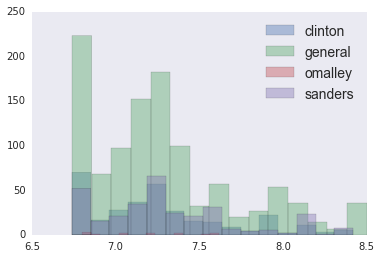

In [53]:
plt.figure(figsize=(6,4))
for c in each_cand_sent:
    plt.hist(c[2],bins=15,alpha=0.4)
plt.legend(each_cand_sent.index.values.astype(str),fontsize=14)

In [ ]:
def process(rdd,json_terms,debate_party,domain_name='sentiment',n_parts=10):
    try:


            if accum.value > 0:
                accum2 = rdd.context.accumulator(0)
                try:
                    scored = scored.filter(lambda score: score[0][0] is not None).cache()
                except Exception,e:
                    print 'nothing left after filtering out no-scores'

                scored.foreach(lambda x: accum2.add(1))
                if accum2.value > 1: # we want at least 2 tweets for highest and lowest scoring
                    high_parts = scored.takeOrdered(1, key = lambda x: -x[0][0])[0]
                    high_scores, high_tweet = high_parts
                    
                    #print 'high scores'
                    #print high_scores
                    high_avg = str(high_scores[0])
                    high_tweet = high_tweet.encode('utf8').decode('ascii','ignore')
                    
                    low_parts  = scored.takeOrdered(1, key = lambda x:  x[0][0])[0]
                    
                    low_scores, low_tweet = low_parts
                    #print 'low scores'
                    #print low_scores
                    low_avg = str(low_scores[0])
                    low_tweet = low_tweet.encode('utf8').decode('ascii','ignore')

                else:
                    high_avg = low_avg = high_tweet = low_tweet = ''


                candidate_dict[candidate]['highest_sentiment_tweet'] = '_'.join([high_avg,high_tweet])
                candidate_dict[candidate]['lowest_sentiment_tweet']  = '_'.join([low_avg,low_tweet])  

                sentiment = (result.map(lambda x: (1,x.text))
                                        .reduceByKey(lambda x,y: ' '.join([str(x),str(y)]))
                                        .map( lambda text: emotion(text[1],labMT) )
                                        .collect()
                                 )
                try:
                    sentiment_avg, sentiment_std = sentiment[0]
                except Exception,e:
                    print str(e)
                    print 'sentiment is empty'

                candidate_dict[candidate]['sentiment_avg'] = str(sentiment_avg)
                candidate_dict[candidate]['sentiment_std'] = str(sentiment_std) 

        attrs = []
        import boto3,json
        client = boto3.client('sdb')

        for cname,cdata in candidate_dict.items():
            attrs.append( {'Name':cname,'Value':json.dumps(cdata),'Replace':True} )

        try:
            # write row of data to SDB
            client.put_attributes(
                DomainName= domain_name,
                ItemName  = str(time.time()),
                Attributes= attrs 
            ) 
        except Exception,e:
            print 'sdb write error: {}'.format(str(e))

        #rdd.foreachPartition(lambda p: write_to_db(p,level='group'))
    except Exception, e:
        print 
        print 'THERE IS AN ERROR!!!!'
        print str(e)
        print
        pass

